# phonon calculation style

**Lucas M. Hale**, [lucas.hale@nist.gov](mailto:lucas.hale@nist.gov?Subject=ipr-demo), *Materials Science and Engineering Division, NIST*.

## Introduction

The phonon calculation style applies small atomic displacements to a unit cell system and evaluates the forces on the atoms to evaluate phonon-based properties.

### Version notes

- 2019-07-30: Notebook added.
- 2021-02-25: Quasiharmonic calculations added.

### Additional dependencies

- [spglib](https://atztogo.github.io/spglib/python-spglib.html)
- [phonopy](https://atztogo.github.io/phonopy/)
- [seekpath](https://pypi.org/project/seekpath/)

### Disclaimers

- [NIST disclaimers](http://www.nist.gov/public_affairs/disclaimer.cfm)


## Method and Theory

Starting with an initial system, [spglib](https://atztogo.github.io/spglib/python-spglib.html) is used to identify the associated primitive unit cell.  The primitive cell is passed to [phonopy](https://atztogo.github.io/phonopy/), which constructs super cell systems with small atomic displacements.  A LAMMPS calculation is performed on the displaced systems to evaluate the atomic forces on each atom without relaxing.  The measured atomic forces are then passed back to phonopy, which computes force constants for the system.  Quasiharmonic approximation calculations can also be performed, where the phonons are evaluated at multiple strains of the system and used to estimate additional thermodynamic data.
 
See [phonopy](https://atztogo.github.io/phonopy/) documentation for more details about the package and the associated theory.


## Demonstration

### 1. Setup

#### 1.1. Library imports

Import libraries needed by the calculation. The external libraries used are:

- [numpy](http://www.numpy.org/)

- [DataModelDict](https://github.com/usnistgov/DataModelDict)

- [atomman](https://github.com/usnistgov/atomman)

- [iprPy](https://github.com/usnistgov/iprPy)

- [spglib](https://atztogo.github.io/spglib/python-spglib.html)

- [phonopy](https://atztogo.github.io/phonopy/)

- [seekpath](https://pypi.org/project/seekpath/)

In [1]:
# Standard library imports
from pathlib import Path
import os
import sys
import uuid
import shutil
import datetime
from collections import OrderedDict
from math import floor
from copy import deepcopy

# http://www.numpy.org/
import numpy as np

# https://matplotlib.org/
import matplotlib.pyplot as plt

# https://atztogo.github.io/spglib/python-spglib.html
import spglib

# https://atztogo.github.io/phonopy/phonopy-module.html
import phonopy

# https://github.com/usnistgov/DataModelDict 
from DataModelDict import DataModelDict as DM

# https://github.com/usnistgov/atomman 
import atomman as am
import atomman.lammps as lmp
import atomman.unitconvert as uc

# https://github.com/usnistgov/iprPy
import iprPy

from IPython.display import Image

print('Notebook last executed on', datetime.date.today(), 'using iprPy version', iprPy.__version__)

Notebook last executed on 2021-03-03 using iprPy version 0.10.4


#### 1.2. Default calculation setup

In [2]:
# Specify calculation style
calc_style = 'phonon'

# If workingdir is already set, then do nothing (already in correct folder)
try:
    workingdir = workingdir

# Change to workingdir if not already there
except:
    workingdir = Path('calculationfiles', calc_style)
    if not workingdir.is_dir():
        workingdir.mkdir(parents=True)
    os.chdir(workingdir)
    
# Initialize connection to library
library = iprPy.Library()

### 2. Assign values for the calculation's run parameters

#### 2.1. Specify system-specific paths

- __lammps_command__ is the LAMMPS command to use (required).

- __mpi_command__ MPI command for running LAMMPS in parallel. A value of None will run simulations serially.

In [3]:
lammps_command = 'lmp_serial'
mpi_command = None

#### 2.2. Load interatomic potential

- __potential_name__ gives the name of the potential_LAMMPS reference record in the iprPy library to use for the calculation.  

- __potential__ is an atomman.lammps.Potential object (required).

In [4]:
potential_name = '1999--Mishin-Y--Ni--LAMMPS--ipr1'

# Retrieve potential and parameter file(s)
potential = library.get_lammps_potential(id=potential_name, getfiles=True)

#### 2.3. Load initial unit cell system

- __ucell__ is an atomman.System representing a fundamental unit cell of the system (required).  Here, this is loaded from the database for the prototype.

In [5]:
# Create ucell by loading prototype record
ucell = am.load('crystal', potential=potential, family='A1--Cu--fcc', database=library)

print(ucell)

avect =  [ 3.520,  0.000,  0.000]
bvect =  [ 0.000,  3.520,  0.000]
cvect =  [ 0.000,  0.000,  3.520]
origin = [ 0.000,  0.000,  0.000]
natoms = 4
natypes = 1
symbols = ('Ni',)
pbc = [ True  True  True]
per-atom properties = ['atype', 'pos']
     id |   atype |  pos[0] |  pos[1] |  pos[2]
      0 |       1 |   0.000 |   0.000 |   0.000
      1 |       1 |   0.000 |   1.760 |   1.760
      2 |       1 |   1.760 |   0.000 |   1.760
      3 |       1 |   1.760 |   1.760 |   0.000


#### 2.4. Modify system

- __sizemults__ list of three integers specifying how many times the ucell vectors of $a$, $b$ and $c$ are replicated in creating system.

In [6]:
sizemults = [3, 3, 3]

#### 2.5. Specify calculation-specific run parameters

- __displacementdistance__ is the displacement distance scalar to use when applying random displacements to the atoms to compute the force constants.   
- __symmetryprecision__ is the absolute precision tolerance to use in determining crystal symmetry elements for identifying the primitive unit cell.   
- __strainrange__ is the size of the largest strain used for the quasiharmonic calculations.
- __numstrains__ is the number of strain states to use for the quasiharmonic calculation.  Needs to be odd and either 1 or greater than or equal to 5.  If set to 1, then the quasiharmonic calculations will not be performed.

In [7]:
displacementdistance = uc.set_in_units(0.01, 'angstrom')
symmetryprecision = 1e-5
strainrange = 0.01
numstrains = 5

### 3. Define calculation function(s) and generate template LAMMPS script(s)

#### 3.1. phonon.template

In [8]:
with open('phonon.template', 'w') as f:
    f.write("""# LAMMPS input script that evaluates atomic forces without relaxing

box tilt large

<atomman_system_pair_info>

thermo_style custom step pe
thermo_modify format float %.13e

dump dumpy all custom 1 forces.dump id type x y z fx fy fz
dump_modify dumpy format <dump_modify_format>

run 0""")

#### 3.2. phonon_quasiharmonic()

In [9]:
def phonon_quasiharmonic(lammps_command, ucell, potential, mpi_command=None, a_mult=3, b_mult=3, c_mult=3,
           distance=0.01, symprec=1e-5, strainrange=0.01, numstrains=5):
    """
    Function that performs phonon and quasiharmonic approximation calculations
    using phonopy and LAMMPS.

    Parameters
    ----------
    lammps_command :str
        Command for running LAMMPS.
    ucell : atomman.System
        The unit cell system to perform the calculation on.
    potential : atomman.lammps.Potential
        The LAMMPS implemented potential to use.
    mpi_command : str, optional
        The MPI command for running LAMMPS in parallel.  If not given, LAMMPS
        will run serially.
    a_mult : int, optional
        The a size multiplier to use on ucell before running the phonon
        calculation.  Must be an int and not a tuple.  Default value is 3.
    b_mult : int, optional
        The b size multiplier to use on ucell before running the phonon
        calculation.  Must be an int and not a tuple.  Default value is 3.
    c_mult : int, optional
        The c size multiplier to use on ucell before running the phonon
        calculation.  Must be an int and not a tuple.  Default value is 3.
    distance : float, optional
        The atomic displacement distance used for computing the phonons.
        Default value is 0.01.
    symprec : float, optional
        Absolute length tolerance to use in identifying symmetry of atomic
        sites and system boundaries. Default value is 1e-5.
    strainrange : float, optional
        The range of strains to apply to the unit cell to use with the
        quasiharmonic calculations.  Default value is 0.01.
    numstrains : int, optional
        The number of strains to use for the quasiharmonic calculations.
        Must be an odd integer.  If 1, then the quasiharmonic calculations
        will not be performed.  Default value is 5.
    """
    # Build filedict if function was called from iprPy
    try:
        assert __name__ == pkg_name
        calc = iprPy.load_calculation(calculation_style)
        filedict = calc.filedict
    except:
        filedict = {}

    # Get lammps units
    lammps_units = lmp.style.unit(potential.units)
    
    # Get lammps version date
    lammps_date = lmp.checkversion(lammps_command)['date']
    
    # Get original box vectors
    vects = ucell.box.vects

    # Generate the range of strains
    if numstrains == 1:
        zerostrain = phononcalc(lammps_command, ucell, potential,
                                mpi_command=mpi_command,
                                a_mult=a_mult, b_mult=b_mult, c_mult=c_mult,
                                distance=distance, symprec=symprec,
                                lammps_date=lammps_date)
        phonons = [zerostrain['phonon']]
        qha = None

    elif numstrains % 2 == 0 or numstrains < 5:
        raise ValueError('Invalid number of strains: must be odd and 1 or >= 5')
    else:
        strains = np.linspace(-strainrange, strainrange, numstrains)
        istrains = np.linspace(-(numstrains-1)/2, (numstrains-1)/2, numstrains, dtype=int)

        volumes = []
        energies = []
        phonons = []
        temperatures = None
        free_energy = None
        heat_capacity = None
        entropy = None

        # Loop over all strains
        for istrain, strain in zip(istrains, strains):

            # Identify the zero strain run
            if istrain == 0:
                zerostrainrun = True
                savefile = 'phonopy_params.yaml'
            else:
                zerostrainrun = False
                savefile = f'phonopy_params_{istrain}.yaml'
            
            # Generate system at the strain
            newvects = vects * (1 + strain)
            ucell.box_set(vects=newvects, scale=True)
            volumes.append(ucell.box.volume)
            system = ucell.supersize(a_mult, b_mult, c_mult)

            # Define lammps variables
            lammps_variables = {}
            system_info = system.dump('atom_data', f='disp.dat',
                                    potential=potential,
                                    return_pair_info=True)
            lammps_variables['atomman_system_pair_info'] = system_info

            # Set dump_modify_format based on lammps_date
            if lammps_date < datetime.date(2016, 8, 3):
                lammps_variables['dump_modify_format'] = '"%d %d %.13e %.13e %.13e %.13e %.13e %.13e"'
            else:
                lammps_variables['dump_modify_format'] = 'float %.13e'

            # Write lammps input script
            template_file = 'phonon.template'
            lammps_script = 'phonon.in'
            template = iprPy.tools.read_calc_file(template_file, filedict)
            with open(lammps_script, 'w') as f:
                f.write(iprPy.tools.filltemplate(template, lammps_variables, '<', '>'))

            # Run LAMMPS
            output = lmp.run(lammps_command, 'phonon.in', mpi_command=mpi_command)

            # Extract system energy
            thermo = output.simulations[0]['thermo']
            energy = uc.set_in_units(thermo.PotEng.values[-1], lammps_units['energy'])

            # Scale energy by sizemults and append to list
            energies.append(energy / (a_mult * b_mult * c_mult))

            # Compute phonon info for ucell
            phononinfo = phononcalc(lammps_command, ucell, potential, mpi_command=mpi_command,
                                    a_mult=a_mult, b_mult=b_mult, c_mult=c_mult,
                                    distance=distance, symprec=symprec, savefile=savefile,
                                    plot=zerostrainrun, lammps_date=lammps_date)
            phonons.append(phononinfo['phonon'])
            
            # Extract temperature values from the first run
            if temperatures is None:
                temperatures = phononinfo['thermal_properties']['temperatures']
                
                # Initialize QHA input arrays
                free_energy = np.empty((len(temperatures), len(strains)))
                heat_capacity = np.empty((len(temperatures), len(strains)))
                entropy = np.empty((len(temperatures), len(strains)))
            
            # Get values for zerostrainrun
            if zerostrainrun is True:
                zerostrain = phononinfo
            
            # Copy values to qha input arrays
            free_energy[:, istrain] = phononinfo['thermal_properties']['free_energy']
            entropy[:, istrain] = phononinfo['thermal_properties']['entropy']
            heat_capacity[:, istrain] = phononinfo['thermal_properties']['heat_capacity']
        
        # Compute qha
        try:
            qha = phonopy.PhonopyQHA(volumes=volumes,
                        electronic_energies=energies,
                        temperatures=temperatures,
                        free_energy=free_energy,
                        cv=heat_capacity,
                        entropy=entropy)
        except:
            qha = None
    
    results = {}    
    
    # Add phonopy objects
    results['phonon_objects'] = phonons
    results['qha_object'] = qha
    
    # Extract zerostrain properties
    results['band_structure'] = zerostrain['band_structure']
    results['density_of_states'] = zerostrain['dos']

    # Convert units on thermal properties
    results['thermal_properties'] = zerostrain['thermal_properties']
    results['thermal_properties']['temperature'] = results['thermal_properties'].pop('temperatures')
    results['thermal_properties']['Helmholtz'] = uc.set_in_units(results['thermal_properties'].pop('free_energy'), 'kJ/mol')
    results['thermal_properties']['entropy'] = uc.set_in_units(results['thermal_properties'].pop('entropy'), 'J/K/mol')
    results['thermal_properties']['heat_capacity_v'] = uc.set_in_units(results['thermal_properties'].pop('heat_capacity'), 'J/K/mol')
    
    if qha is not None:

        # Create QHA plots
        qha.plot_bulk_modulus()
        plt.xlabel('Volume ($Å^3$)', size='large')
        plt.ylabel('Energy ($eV$)', size='large')
        plt.savefig('bulk_modulus.png', dpi=400, bbox_inches='tight')
        plt.close()

        qha.plot_helmholtz_volume()
        plt.savefig('helmholtz_volume.png', dpi=400)
        plt.close()

        # Package volume vs energy scans
        results['volume_scan'] = {}
        results['volume_scan']['volume'] = np.array(volumes)
        results['volume_scan']['strain'] = strains
        results['volume_scan']['energy'] = np.array(energies)
        
        # Compute and add QHA properties
        properties = qha.get_bulk_modulus_parameters()
        results['E0'] = uc.set_in_units(properties[0], 'eV')
        results['B0'] = uc.set_in_units(properties[1], 'eV/angstrom^3')
        results['B0prime'] = uc.set_in_units(properties[2], 'eV/angstrom^3')
        results['V0'] = uc.set_in_units(properties[3], 'angstrom^3')
        
        results['thermal_properties']['volume'] = uc.set_in_units(np.hstack([qha.get_volume_temperature(), np.nan]), 'angstrom^3')
        results['thermal_properties']['thermal_expansion'] = np.hstack([qha.get_thermal_expansion(), np.nan])
        results['thermal_properties']['Gibbs'] = uc.set_in_units(np.hstack([qha.get_gibbs_temperature(), np.nan]), 'eV')
        results['thermal_properties']['bulk_modulus'] = uc.set_in_units(np.hstack([qha.get_bulk_modulus_temperature(), np.nan]), 'GPa')
        results['thermal_properties']['heat_capacity_p_numerical'] = uc.set_in_units(np.hstack([qha.get_heat_capacity_P_numerical(), np.nan]), 'J/K/mol')
        results['thermal_properties']['heat_capacity_p_polyfit'] = uc.set_in_units(np.hstack([qha.get_heat_capacity_P_polyfit(), np.nan]), 'J/K/mol')
        results['thermal_properties']['gruneisen'] = np.hstack([qha.get_gruneisen_temperature(), np.nan])
    
    return results

#### 3.3. phononcalc()

In [10]:
def phononcalc(lammps_command, ucell, potential, mpi_command=None,
               a_mult=3, b_mult=3, c_mult=3, distance=0.01, symprec=1e-5, 
               savefile='phonopy_params.yaml', plot=True, lammps_date=None):
    """
    Uses phonopy to compute the phonons for a unit cell structure using a
    LAMMPS interatomic potential.

    Parameters
    ----------
    lammps_command :str
        Command for running LAMMPS.
    ucell : atomman.System
        The unit cell system to perform the calculation on.
    potential : atomman.lammps.Potential
        The LAMMPS implemented potential to use.
    mpi_command : str, optional
        The MPI command for running LAMMPS in parallel.  If not given, LAMMPS
        will run serially.
    a_mult : int, optional
        The a size multiplier to use on ucell before running the phonon
        calculation.  Must be an int and not a tuple.  Default value is 3.
    b_mult : int, optional
        The b size multiplier to use on ucell before running the phonon
        calculation.  Must be an int and not a tuple.  Default value is 3.
    c_mult : int, optional
        The c size multiplier to use on ucell before running the phonon
        calculation.  Must be an int and not a tuple.  Default value is 3.
    distance : float, optional
        The atomic displacement distance used for computing the phonons.
        Default value is 0.01.
    symprec : float, optional
        Absolute length tolerance to use in identifying symmetry of atomic
        sites and system boundaries. Default value is 1e-5.
    savefile: str, optional
        The name of the phonopy yaml backup file.  Default value is
        'phonopy_params.yaml'.
    plot : bool, optional
        Flag indicating if band structure and DOS figures are to be generated.
        Default value is True.
    lammps_date : datetime.date, optional
        The version date associated with lammps_command.  If not given, the
        version will be identified.
    """
    # Build filedict if function was called from iprPy
    try:
        assert __name__ == pkg_name
        calc = iprPy.load_calculation(calculation_style)
        filedict = calc.filedict
    except:
        filedict = {}

    # Get lammps units
    lammps_units = lmp.style.unit(potential.units)
    
    # Get lammps version date
    if lammps_date is None:
        lammps_date = lmp.checkversion(lammps_command)['date']
    
    # Use spglib to find primitive unit cell of ucell
    convcell = ucell.dump('spglib_cell')
    primcell = spglib.find_primitive(convcell, symprec=symprec)
    primucell = am.load('spglib_cell', primcell, symbols=ucell.symbols).normalize()
    
    # Initialize Phonopy object
    phonon = phonopy.Phonopy(primucell.dump('phonopy_Atoms', symbols=potential.elements(primucell.symbols)),
                             [[a_mult, 0, 0], [0, b_mult, 0], [0, 0, c_mult]],
                             factor=phonopy.units.VaspToTHz)
    phonon.generate_displacements(distance=distance)
    
    # Loop over displaced supercells to compute forces
    forcearrays = []
    for supercell in phonon.supercells_with_displacements:
        
        # Save to LAMMPS data file
        system = am.load('phonopy_Atoms', supercell, symbols=primucell.symbols)
        system_info = system.dump('atom_data', f='disp.dat',
                                  potential=potential,
                                  return_pair_info=True)
        
        # Define lammps variables
        lammps_variables = {}
        lammps_variables['atomman_system_pair_info'] = system_info

        # Set dump_modify_format based on lammps_date
        if lammps_date < datetime.date(2016, 8, 3):
            lammps_variables['dump_modify_format'] = '"%d %d %.13e %.13e %.13e %.13e %.13e %.13e"'
        else:
            lammps_variables['dump_modify_format'] = 'float %.13e'

        # Write lammps input script
        template_file = 'phonon.template'
        lammps_script = 'phonon.in'
        template = iprPy.tools.read_calc_file(template_file, filedict)
        with open(lammps_script, 'w') as f:
            f.write(iprPy.tools.filltemplate(template, lammps_variables, '<', '>'))
        
        # Run LAMMPS
        lmp.run(lammps_command, 'phonon.in', mpi_command=mpi_command)
        
        # Extract forces from dump file
        forcestructure = am.load('atom_dump', 'forces.dump')
        forces = uc.set_in_units(forcestructure.atoms.force, lammps_units['force'])
        forcearrays.append(forces)
    
    results = {}

    # Set computed forces
    phonon.set_forces(forcearrays)
    
    # Save to yaml file    
    phonon.save(savefile)
    
    # Compute band structure    
    phonon.produce_force_constants()
    phonon.auto_band_structure(plot=plot)
    results['band_structure'] = phonon.get_band_structure_dict()
    if plot:
        plt.ylabel('Frequency (THz)')
        plt.savefig(Path('.', 'band.png'), dpi=400)
        plt.close()
    
    # Compute density of states
    phonon.auto_total_dos(plot=False)
    phonon.auto_projected_dos(plot=False)
    dos = phonon.get_total_dos_dict()
    dos['frequency'] = uc.set_in_units(dos.pop('frequency_points'), 'THz')
    dos['projected_dos'] = phonon.get_projected_dos_dict()['projected_dos']
    results['dos'] = dos
    
    # Compute thermal properties
    phonon.run_thermal_properties()
    results['thermal_properties'] = phonon.get_thermal_properties_dict()
    
    results['phonon'] = phonon
    return results

### 4. Run calculation function(s)

In [11]:
results_dict = phonon_quasiharmonic(lammps_command, ucell, potential,
                                    mpi_command = mpi_command,
                                    a_mult = sizemults[0],
                                    b_mult = sizemults[1],
                                    c_mult = sizemults[2],
                                    distance = displacementdistance,
                                    symprec = symmetryprecision,
                                    strainrange = strainrange,
                                    numstrains = numstrains)

In [12]:
results_dict.keys()

dict_keys(['phonon_objects', 'qha_object', 'band_structure', 'density_of_states', 'thermal_properties', 'volume_scan', 'E0', 'B0', 'B0prime', 'V0'])

### 5. Report results

The calculation both returns results_dict containing phonon information and generates files. 

#### 5.1. Phonon properties

In results_dict:

- __phonon_objects__ is a list containing all of the Phonopy objects at all of the strains evaluated.
- __band_structure__ contains the evaluated band structure points for the zero strain structure.
- __density_of_states__ contains the evaluated density of states (both total and projected) for the zero strain structure.
- __thermal_properties__ contains the temperature-dependent Helmholtz free energy, entropy, and constant volume heat capacity.

Generated files:

- __band.png__ plots the band structure for the zero strain structure.
- __phonopy_params.yaml__ is the YAML-formatted Phonopy data that can be read back in to generate a Phonopy object later.  

#### 5.2. Quasiharmonic properties

These are only generated if numstrains is greater than 1.

In results_dict:

- __qha_object__ is the PhonopyQHA object.
- __volume_scan__ contains the energy versus volume evaluations taken from the different strain states.
- __E0, B0, B0prime, V0__ are the energy, Bulk modulus, B' modulus, and volume associated with the interpolated equilibrium state from the volume scan.
- __thermal_properties__ is expanded to also include the temperature-dependent volume, thermal expansion, Gibbs free energy, bulk modulus, constant pressure heat capacity, and Grüneisen parameter.

Generated files:

- __bulk_modulus.png__ plots the volume scan data as it is used to estimate the bulk modulus.  This plot provides a quick visual means of telling if the quasiharmonic analysis is likely good for the strains explored. 
- __helmholtz.png__ plots the helmholtz free energy versus volume.  
- __phonopy_params_\*.yaml__ are the YAML-formatted Phonopy data for the non-zero strains that can be read back in to generate Phonopy objects later. 

Band structure plot and values

keys of "band_structure": dict_keys(['qpoints', 'distances', 'frequencies', 'eigenvectors', 'group_velocities'])


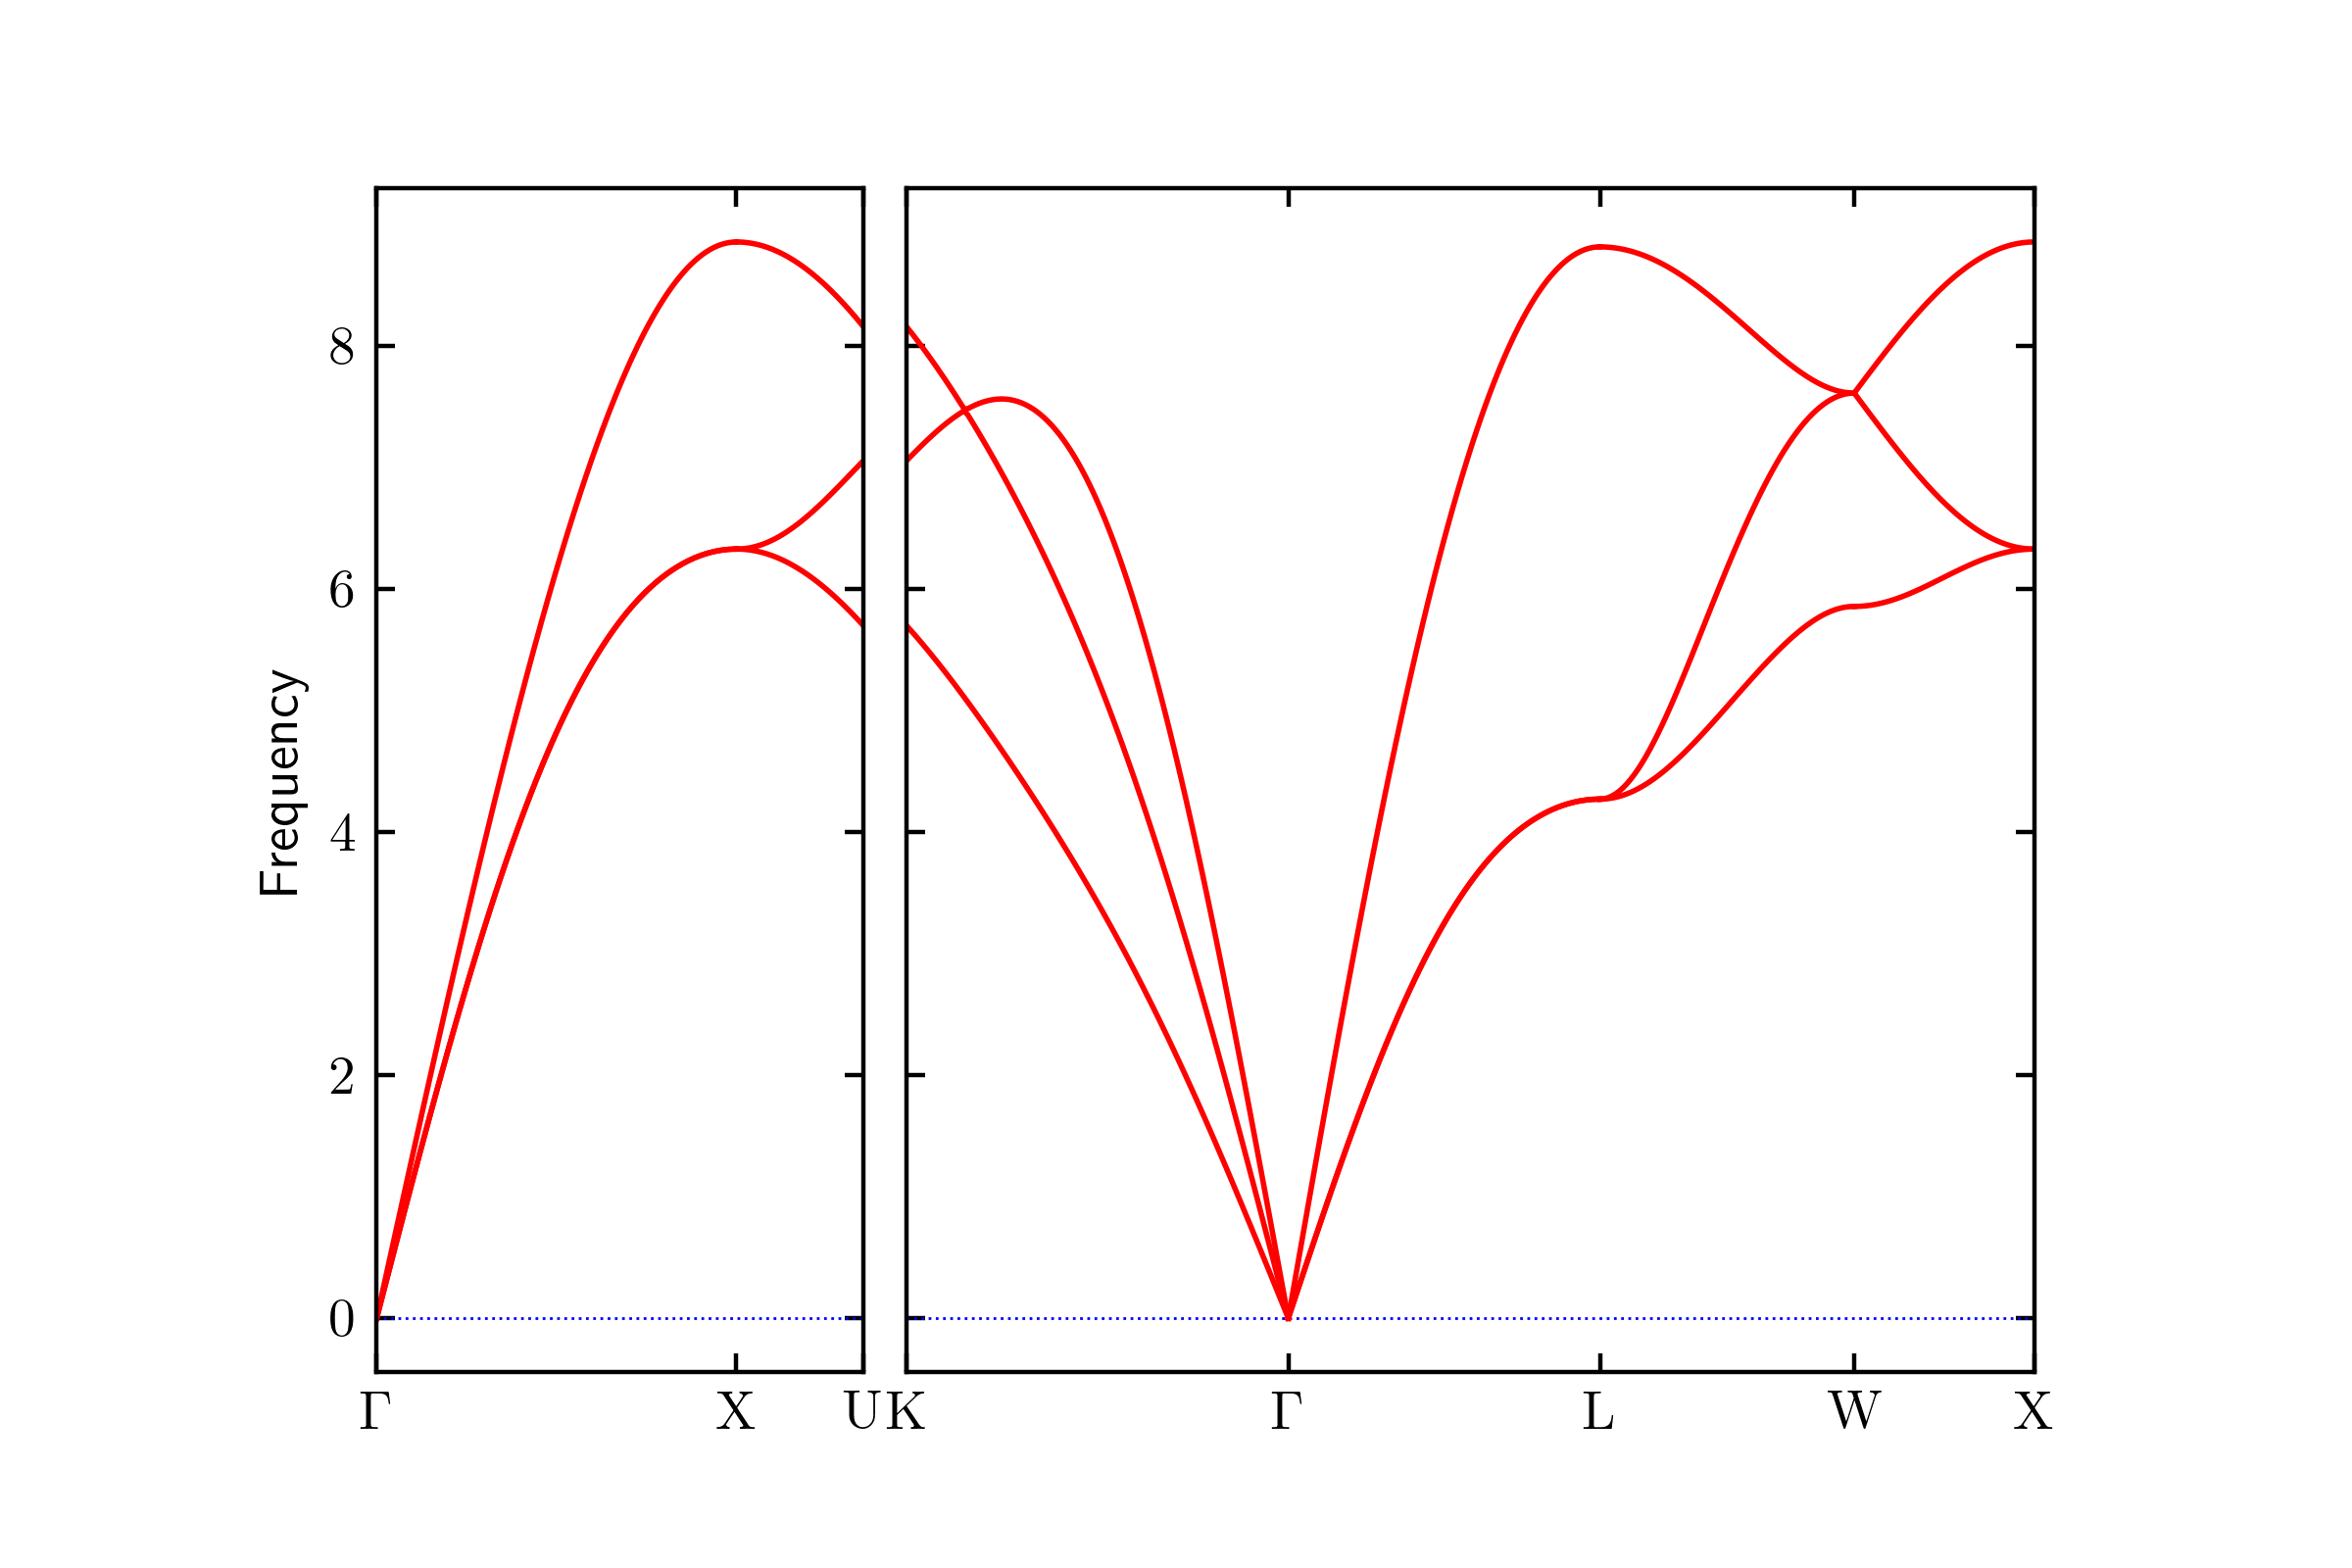

In [13]:
print('keys of "band_structure":', results_dict['band_structure'].keys())
Image("band.png", width=600)

Volume versus energy scan plot and values

keys of "volume_scan": dict_keys(['volume', 'strain', 'energy'])
E0 = -17.800066208638768 eV
B0 = 187.33987540347607 GPa
B0`= 150.3757928181106 GPa
V0 = 43.61354080975212 Å^3


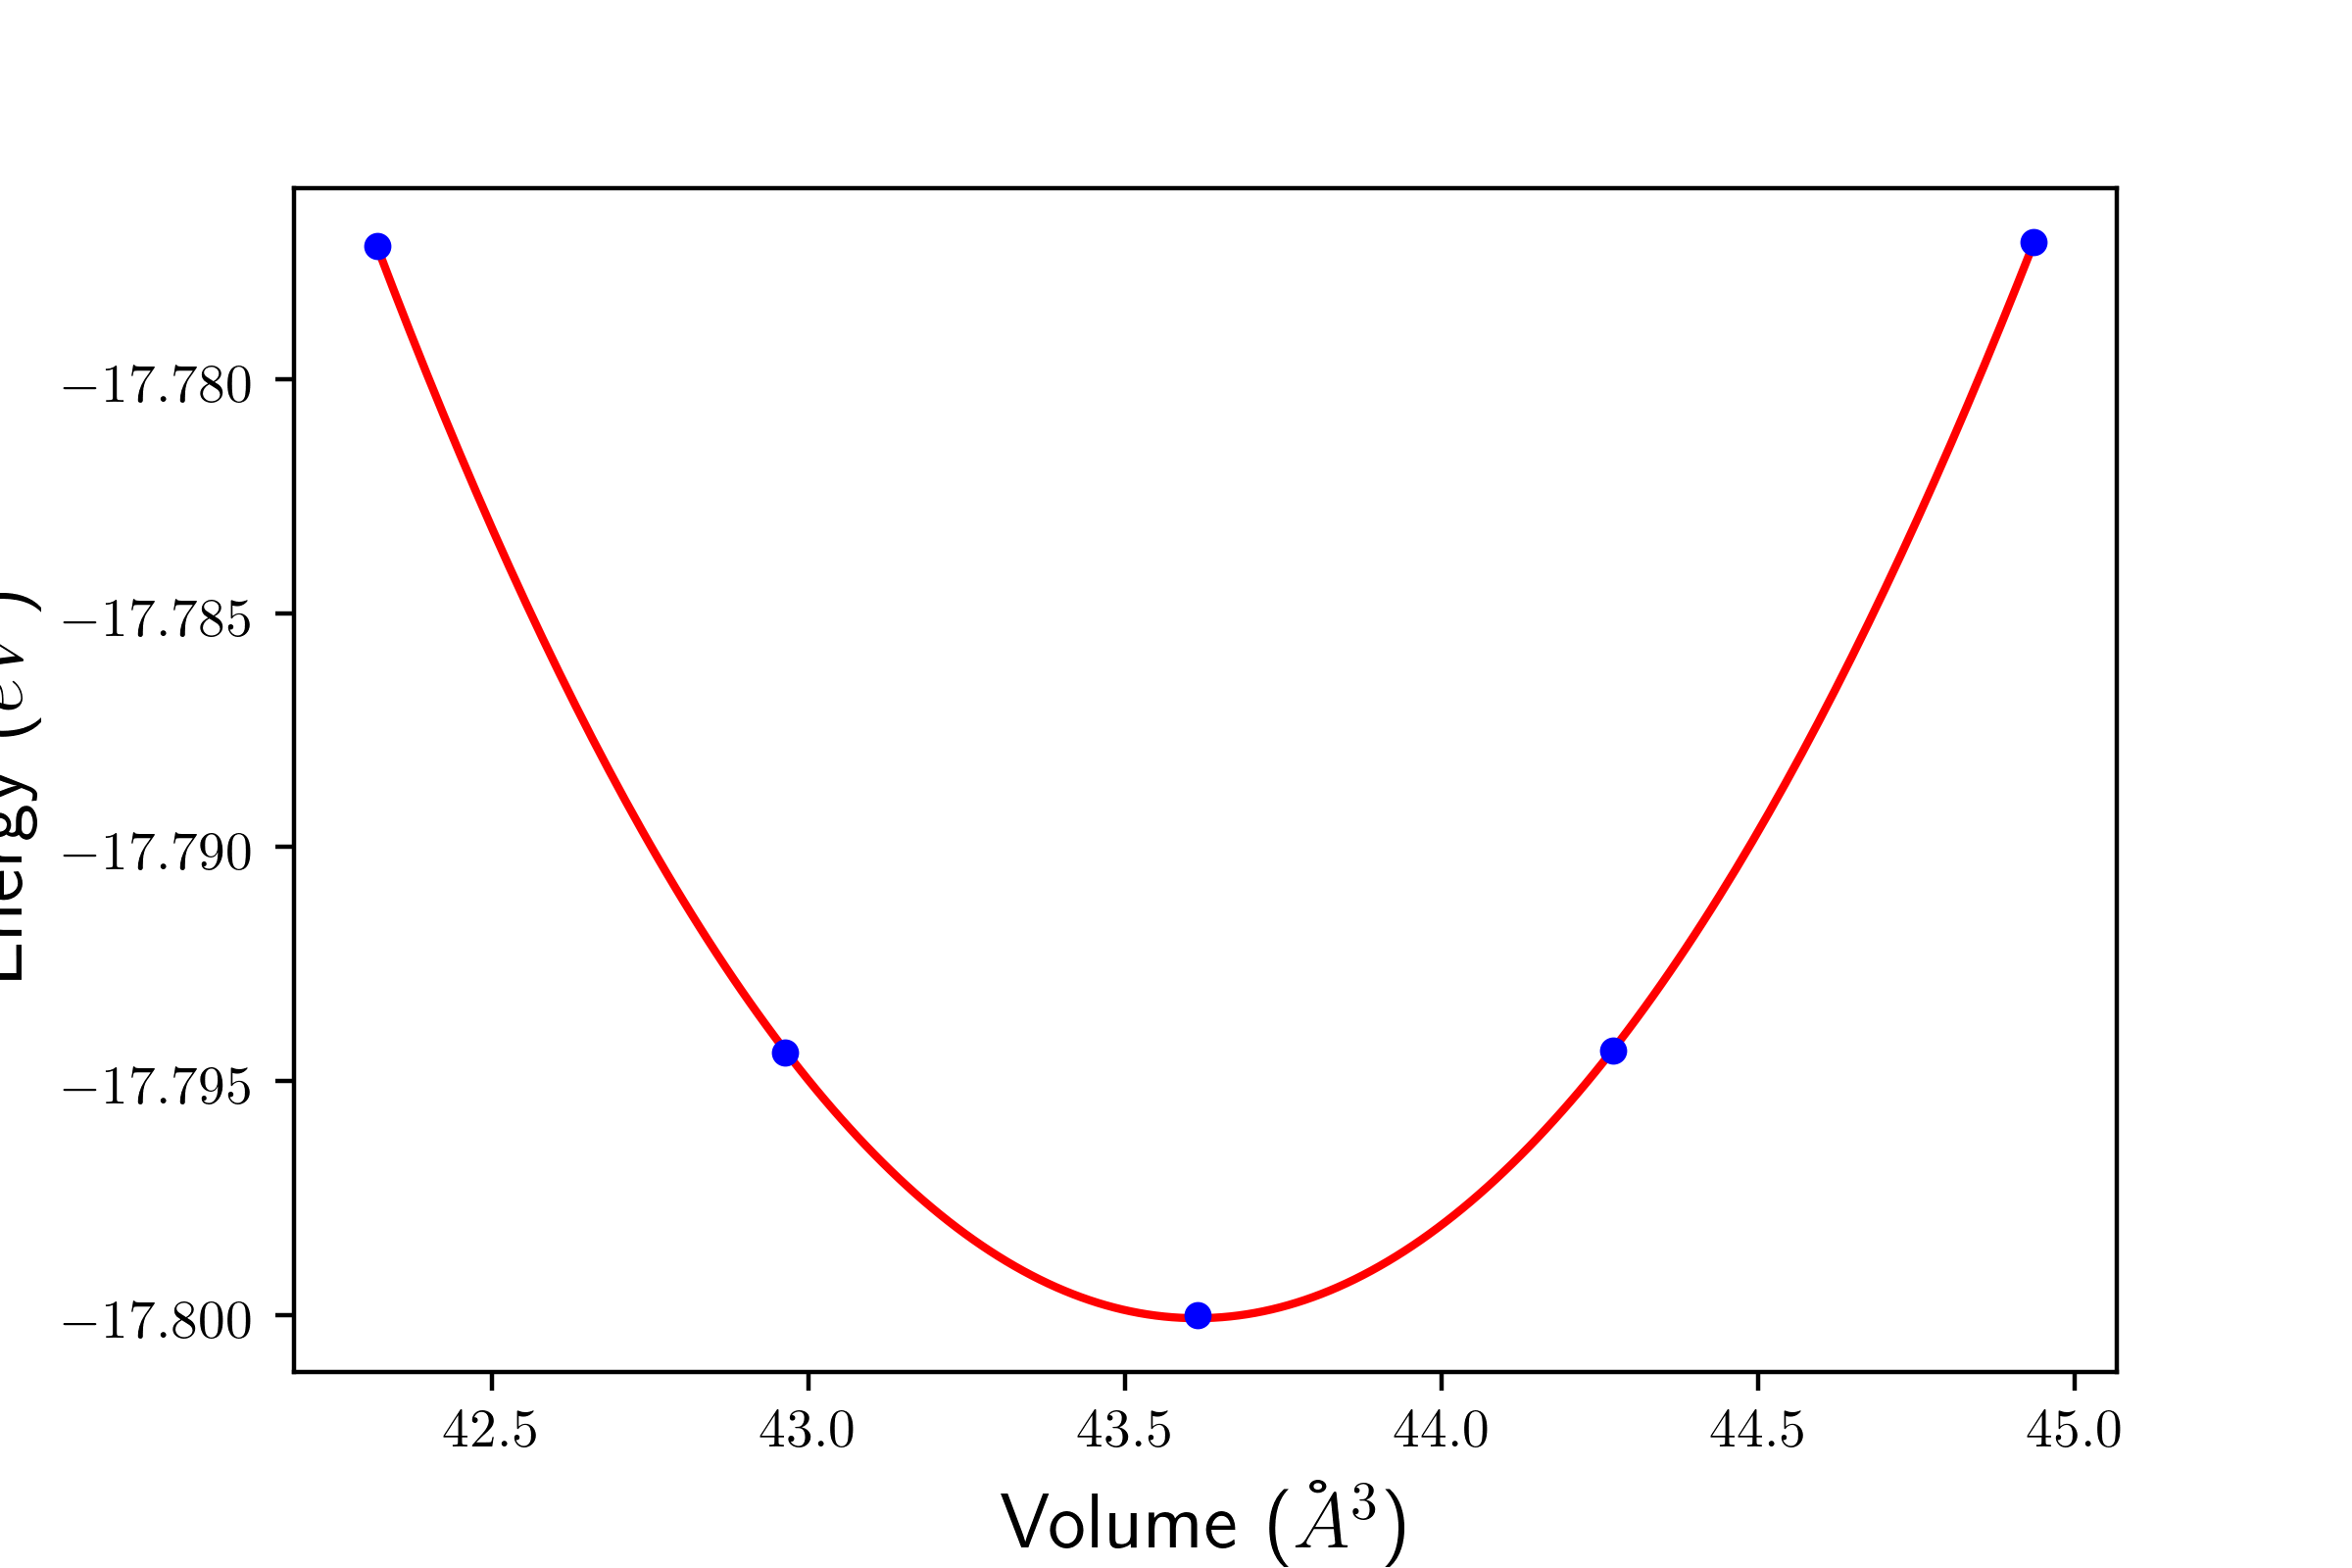

In [14]:
print('keys of "volume_scan":',results_dict['volume_scan'].keys())
print('E0 =', uc.get_in_units(results_dict['E0'], 'eV'), 'eV')
print('B0 =', uc.get_in_units(results_dict['B0'], 'GPa'), 'GPa')
print('B0`=', uc.get_in_units(results_dict['B0prime'], 'GPa'), 'GPa')
print('V0 =', uc.get_in_units(results_dict['V0'], 'Å^3'), 'Å^3')

Image("bulk_modulus.png", width=600)

Helmholtz free energy versus volume plot

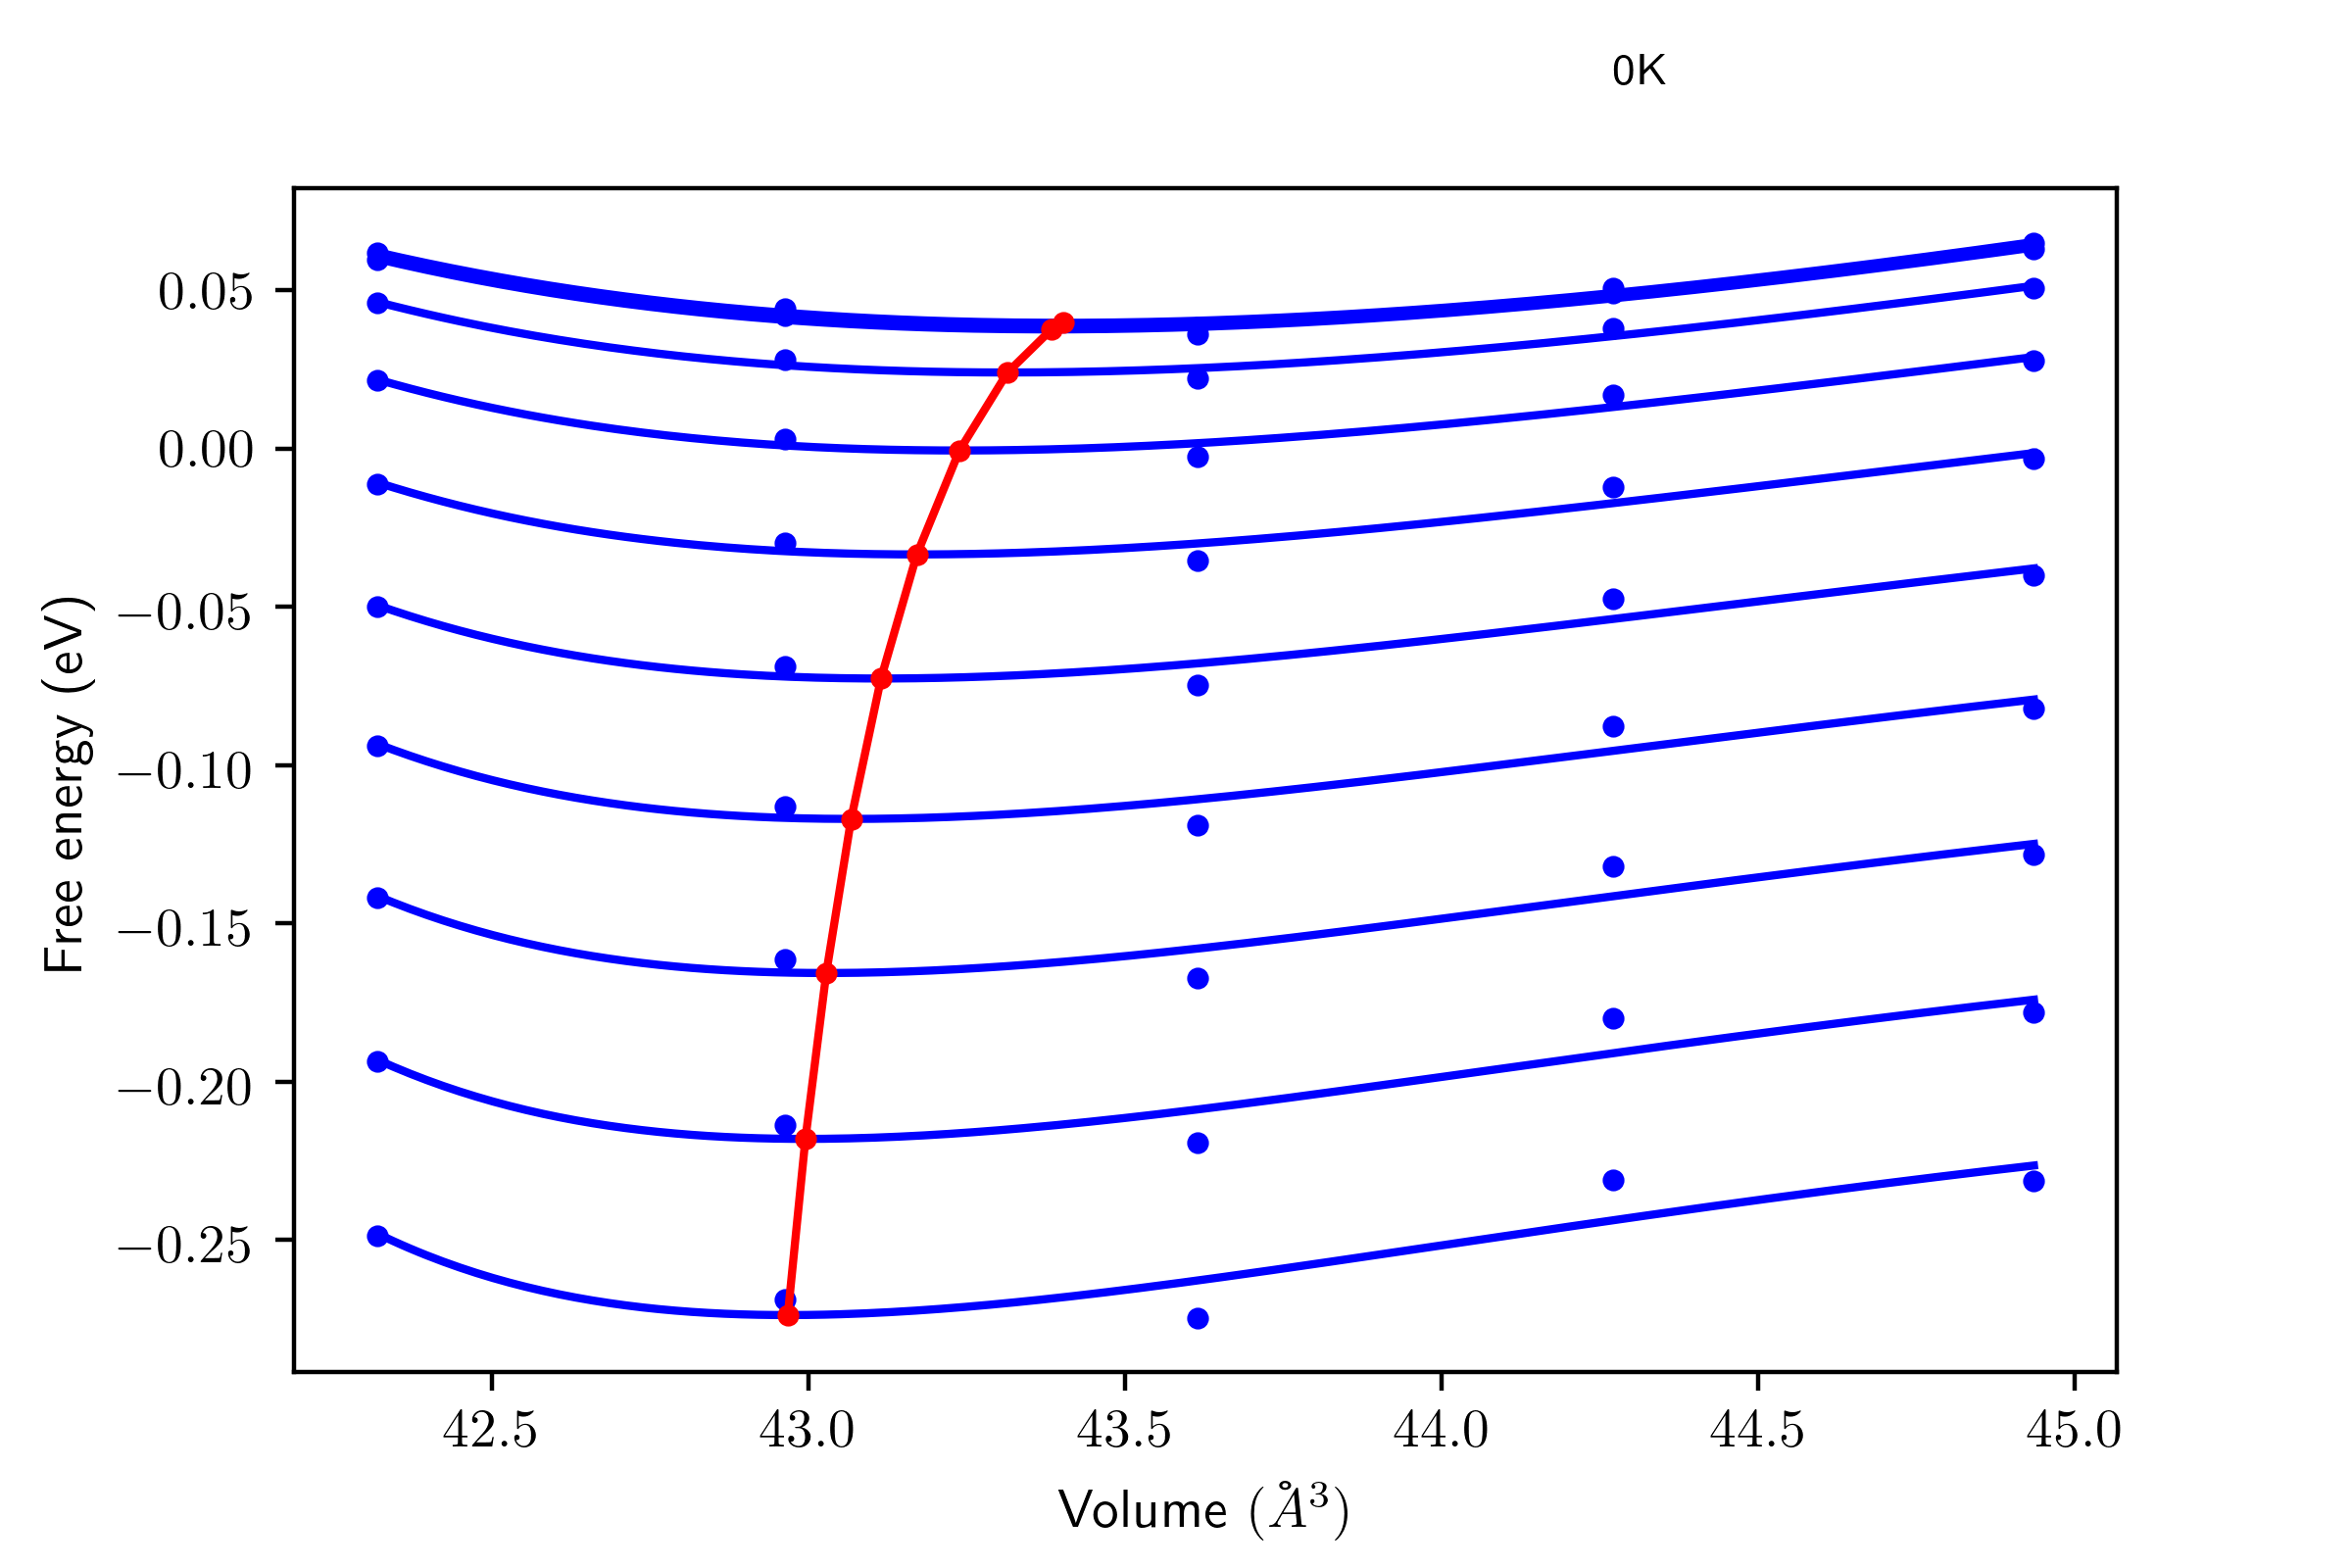

In [15]:
Image("helmholtz_volume.png", width=600)

Density of states

In [31]:
results_dict['density_of_states']['projected_dos']

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.55996438e-06, 2.49594675e-05, 7.64383857e-05,
        1.55996719e-04, 2.63634467e-04, 3.99351630e-04, 7.29686048e-04,
        1.19428880e-03, 1.54440186e-03, 1.93805726e-03, 2.40194799e-03,
        3.07472413e-03, 3.70072970e-03, 4.34986769e-03, 4.99514755e-03,
        5.65484098e-03, 6.37128413e-03, 7.29586737e-03, 8.35668187e-03,
        9.29613157e-03, 1.03829803e-02, 1.15087151e-02, 1.26678925e-02,
        1.38756436e-02, 1.51529765e-02, 1.65209477e-02, 1.78614479e-02,
        1.93887148e-02, 2.11123466e-02, 2.29407042e-02, 2.47048596e-02,
        2.63519337e-02, 2.83224574e-02, 3.02764733e-02, 3.23150026e-02,
        3.45740985e-02, 3.70508209e-02, 3.94088932e-02, 4.188114

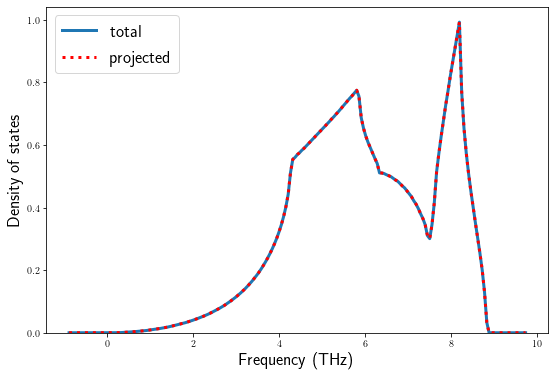

In [30]:
dos = results_dict['density_of_states']

fig = plt.figure(figsize=(9,6))

frequency = uc.get_in_units(dos['frequency'], 'THz')
plt.plot(frequency, dos['total_dos'], '-', lw=3, label='total')
for projected in dos['projected_dos']:
    plt.plot(frequency, projected, 'r:', lw=3, label='projected')
plt.xlabel('Frequency (THz)', size='xx-large')
plt.ylabel('Density of states', size='xx-large')
plt.legend(loc=2, fontsize='xx-large')
plt.ylim(0.0, None)
plt.show()

Thermal properties - pull out temperature

In [17]:
results_dict['thermal_properties'].keys()

thermal = results_dict['thermal_properties']
temperature = thermal['temperature']

Helmholtz and Gibbs free energies versus temperature

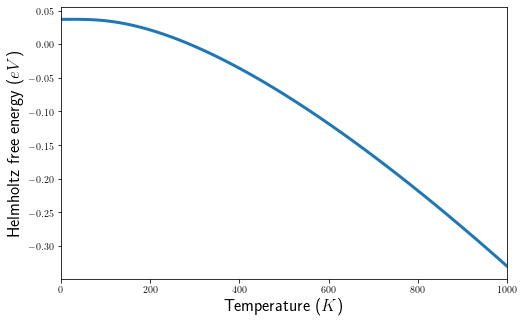

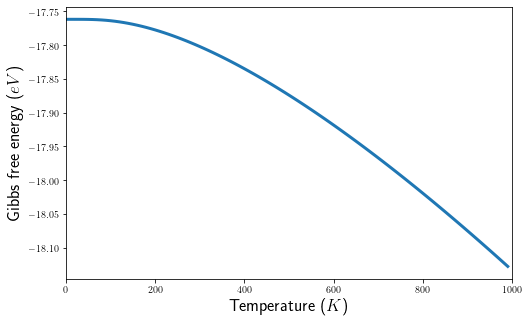

In [18]:
energy_unit = 'eV'
#energy_unit = 'kJ/mol'

fig = plt.figure(figsize=(8,5))
helmholtz = uc.get_in_units(thermal['Helmholtz'], energy_unit)
plt.plot(temperature, helmholtz, '-', lw=3)
plt.xlabel('Temperature ($K$)', size='xx-large')
plt.xlim(0, 1000)
plt.ylabel(f'Helmholtz free energy (${energy_unit}$)', size='xx-large')
plt.show()

fig = plt.figure(figsize=(8,5))
gibbs = uc.get_in_units(thermal['Gibbs'], energy_unit)
plt.plot(temperature, gibbs, '-', lw=3)
plt.xlabel('Temperature ($K$)', size='xx-large')
plt.xlim(0, 1000)
plt.ylabel(f'Gibbs free energy (${energy_unit}$)', size='xx-large')
plt.show()

Entropy and heat capacity versus temperature

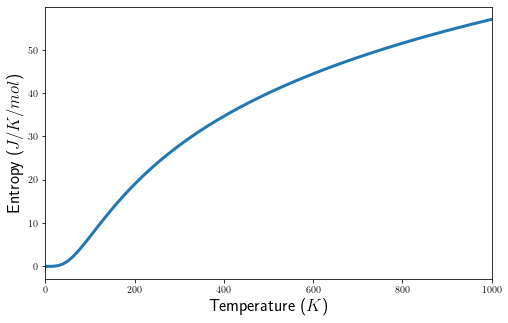

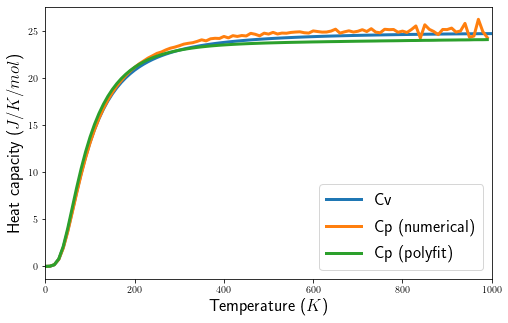

In [19]:
#entropy_unit = 'eV/K'
entropy_unit = 'J/K/mol'

fig = plt.figure(figsize=(8,5))
entropy = uc.get_in_units(thermal['entropy'], entropy_unit)
plt.plot(temperature, entropy, '-', lw=3)
plt.xlabel('Temperature ($K$)', size='xx-large')
plt.xlim(0, 1000)
plt.ylabel(f'Entropy (${entropy_unit}$)', size='xx-large')
plt.show()

fig = plt.figure(figsize=(8,5))
heat_capacity_v = uc.get_in_units(thermal['heat_capacity_v'], entropy_unit)
heat_capacity_p_numerical = uc.get_in_units(thermal['heat_capacity_p_numerical'], entropy_unit)
heat_capacity_p_polyfit = uc.get_in_units(thermal['heat_capacity_p_polyfit'], entropy_unit)

plt.plot(temperature, heat_capacity_v, '-', lw=3, label='Cv')
plt.plot(temperature, heat_capacity_p_numerical, '-', lw=3, label='Cp (numerical)')
plt.plot(temperature, heat_capacity_p_polyfit, '-', lw=3, label='Cp (polyfit)')
plt.xlabel('Temperature ($K$)', size='xx-large')
plt.xlim(0, 1000)
plt.ylabel(f'Heat capacity (${entropy_unit}$)', size='xx-large')
plt.legend(loc=4, fontsize='xx-large')
plt.show()

Volume versus temperature

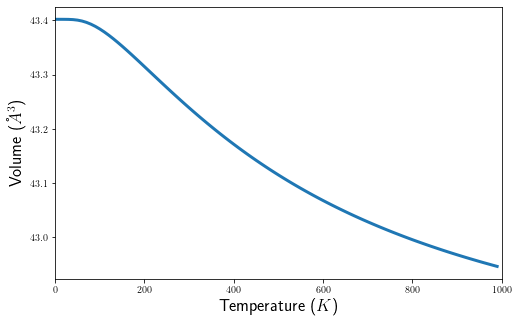

In [20]:
volume_unit = 'Å^3'
#volume_unit = 'nm^3'

fig = plt.figure(figsize=(8,5))
volume = uc.get_in_units(thermal['volume'], volume_unit)
plt.plot(temperature, volume, '-', lw=3)
plt.xlabel('Temperature ($K$)', size='xx-large')
plt.xlim(0, 1000)
plt.ylabel(f'Volume (${volume_unit}$)', size='xx-large')
plt.show()

Thermal expansion versus temperature

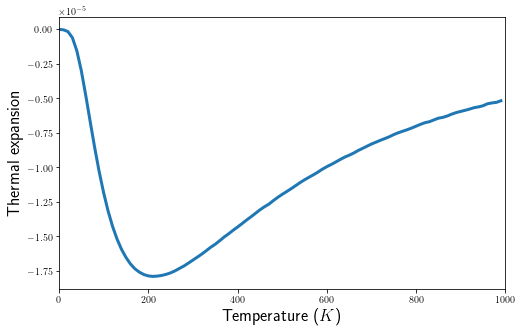

In [21]:
fig = plt.figure(figsize=(8,5))
expansion = thermal['thermal_expansion']
plt.plot(temperature, expansion, '-', lw=3)
plt.xlabel('Temperature ($K$)', size='xx-large')
plt.xlim(0, 1000)
plt.ylabel(f'Thermal expansion', size='xx-large')
plt.show()

Grüneisen parameter versus temperature

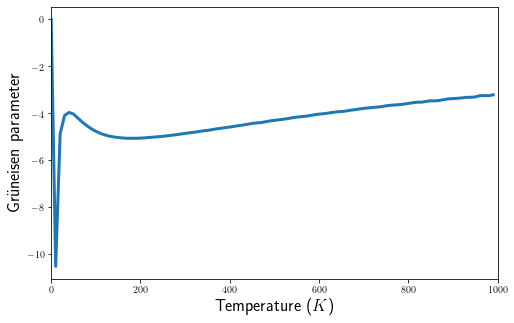

In [22]:
fig = plt.figure(figsize=(8,5))
gruneisen = thermal['gruneisen']
plt.plot(temperature, gruneisen, '-', lw=3)
plt.xlabel('Temperature ($K$)', size='xx-large')
plt.xlim(0, 1000)
plt.ylabel(f'Grüneisen parameter', size='xx-large')
plt.show()

In [24]:
qha = results_dict['qha_object']

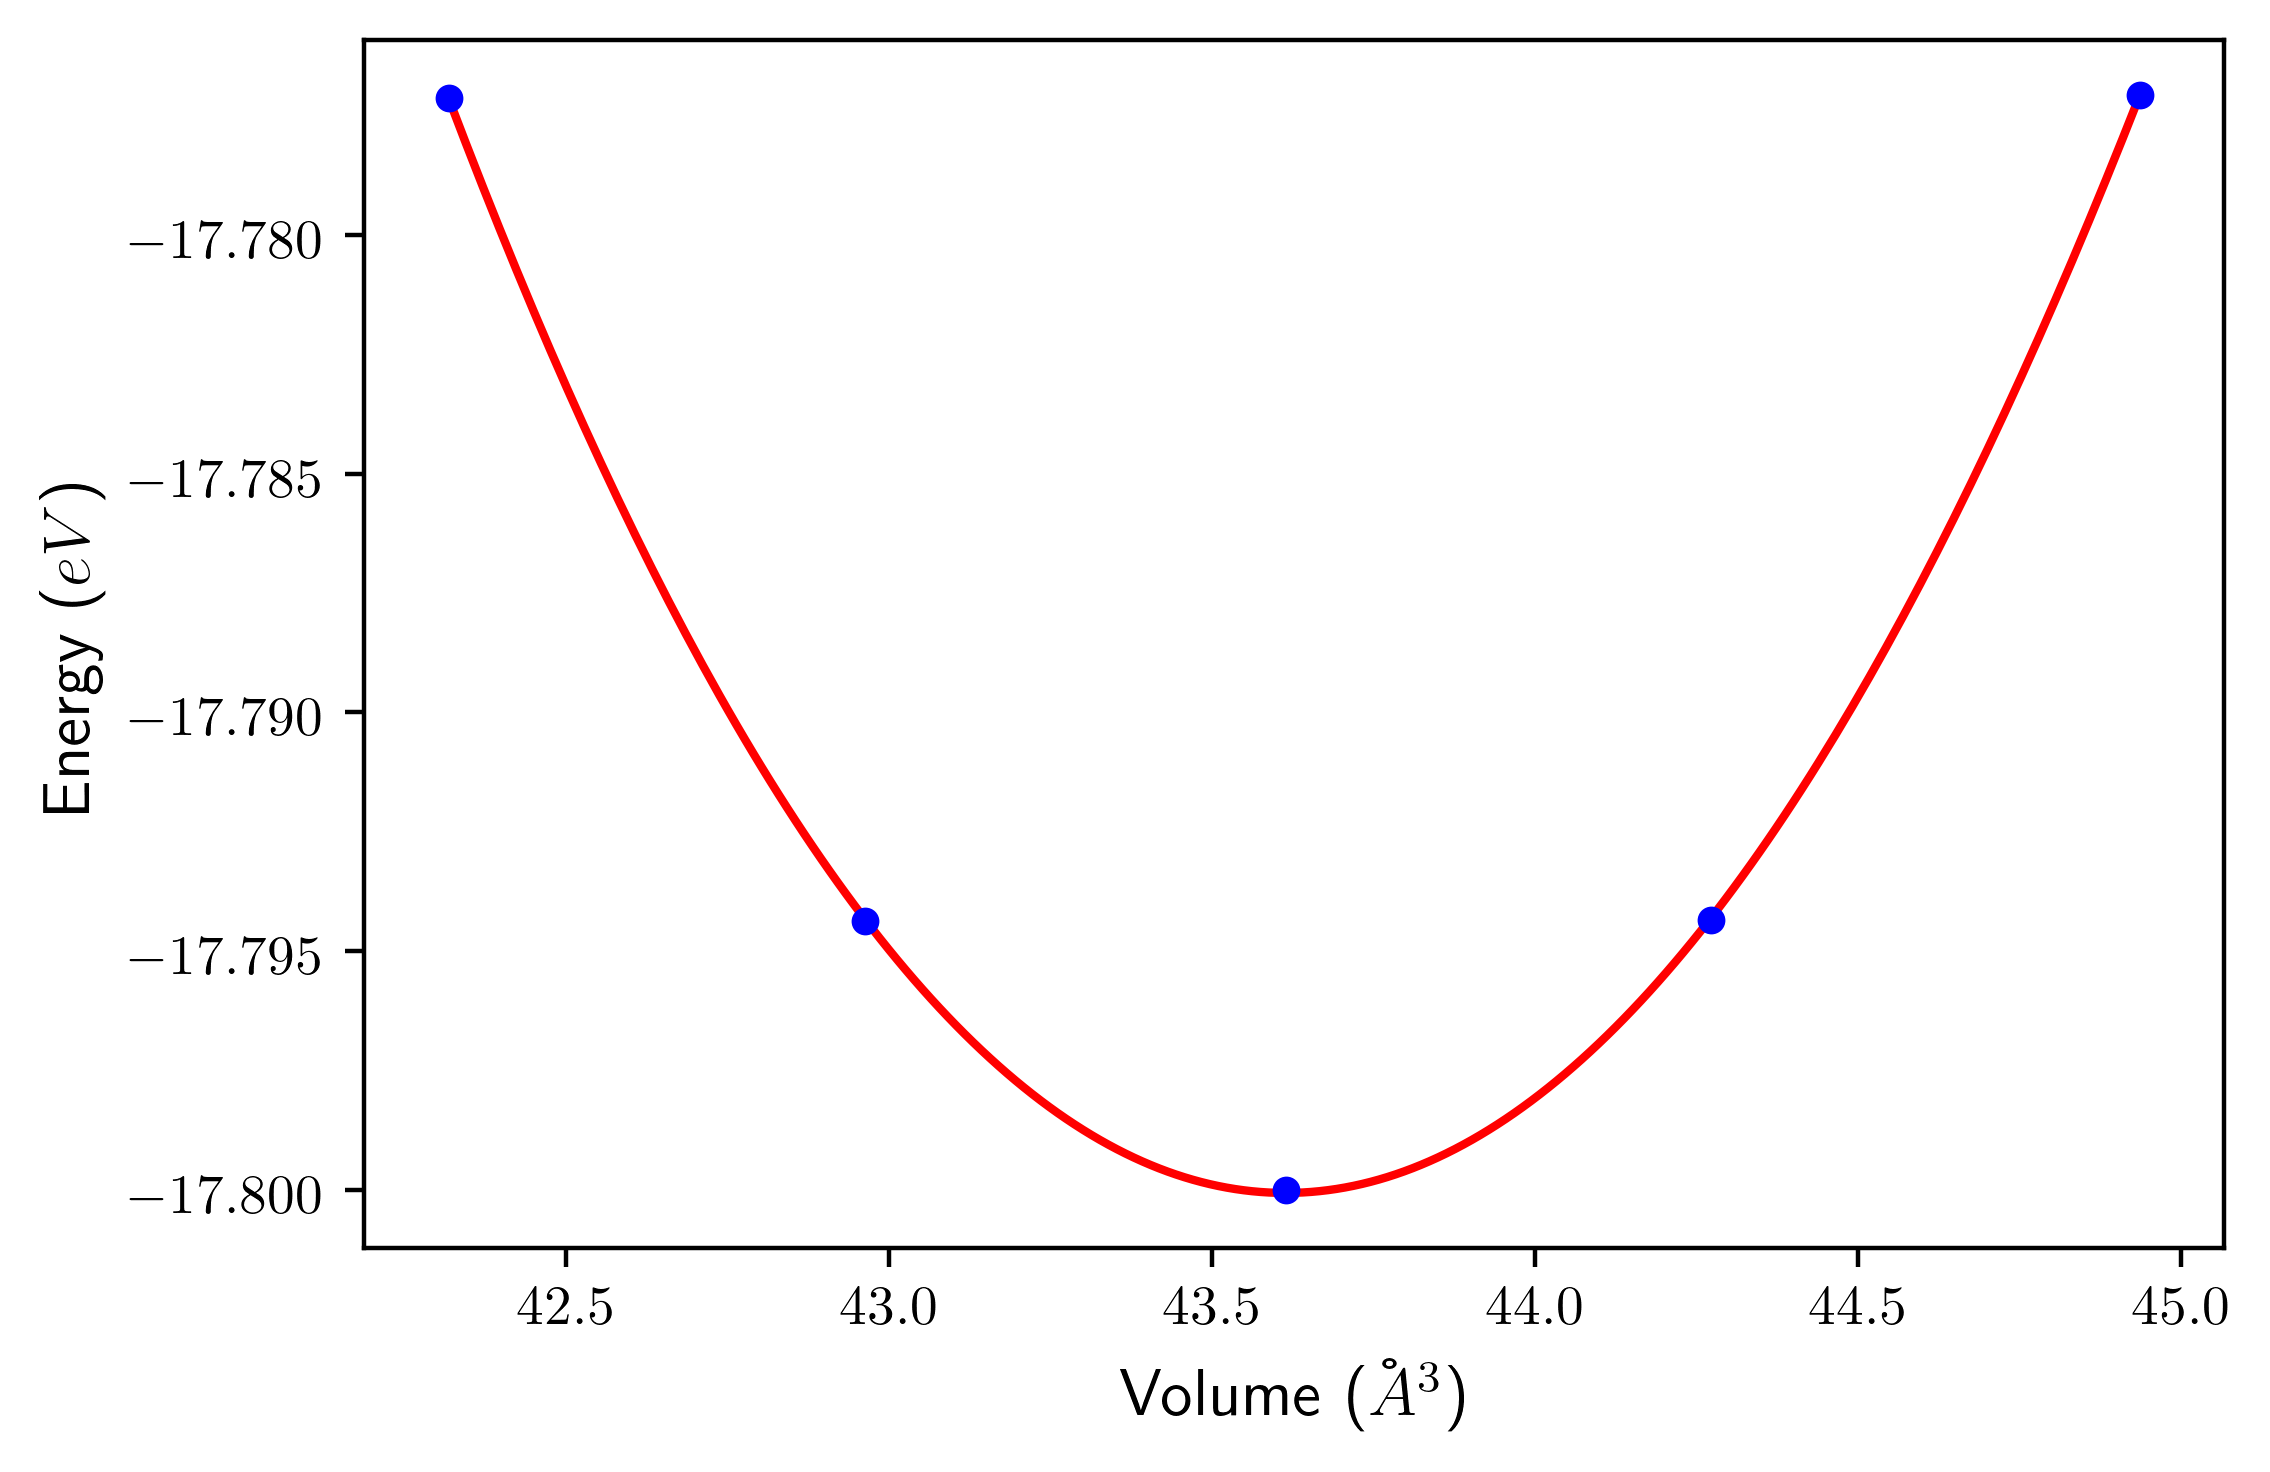

In [29]:
qha.plot_bulk_modulus()
plt.xlabel('Volume ($Å^3$)', size='large')
plt.ylabel('Energy ($eV$)', size='large')
plt.savefig('test.png', dpi=400, bbox_inches='tight')
plt.close()
Image("test.png", width=600)